In [1]:
# This should give version 1.3.3dev!
from pyBBarolo import version
print (version)
from pyBBarolo.BB_interface import libBB
from pyBBarolo.bayesian import BayesianBBarolo
import ctypes, time, copy
from pyBBarolo import Param, Rings, FitMod3D, reshapePointer, vprint, isIterable
import numpy as np
from pyBBarolo.bayesian import BayesianBBarolo
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
import corner


parallel=True
try: 
    from schwimmbad import MultiPool, MPIPool
    from mpi4py import MPI
except ImportError:
    print ("WARNING! Parallelization is disabled. Please install schwimmbad and mpi4py to enable it.")
    parallel = False

try: 
    import dynesty as dyn
    from dynesty.utils import resample_equal
except ImportError:
    raise ImportError("BayesianBB requires the package 'dynesty'. Please install it.")


class BayesianBBaroloMod(BayesianBBarolo):

    def __init__(self,fitsname,**kwargs):
        """ Initialize the BayesianBBarolo class.
    
        Parameters
        ----------
        fitsname : str
            The name of the fits file with the datacube to fit.
        **kwargs : dict
            Any other parameter to be passed to the BBarolo's library.
        """

        super(BayesianBBaroloMod,self).__init__(fitsname,**kwargs)
        self.noise=None
        self.Npix=None

    def _calculate_model(self,rings):
            """ This function calculates a unnormalized model given a set of rings.
            
                Parameters
                ----------
                rings : Rings
                    A Rings object with the parameters of the model.
    
                Returns
                -------
                mod : 3D array
                    A 3D array with the model.
                bhi, blo : 1D arrays
                    The boundaries of the model in the input cube.
                galmod : pointer 
                    A pointer to the Galmod object. Need to be freed after use.
            """
            # Model is built in a smaller array (blo,bhi) that only contains the galaxy 
            # within the last ring. This is to calculate the residuals faster.
            _, ys, xs = self.data.shape
            bhi, blo = (ctypes.c_int * 2)(xs,ys), (ctypes.c_int * 2)(0)
            #libBB.Galfit_getModelSize(self._galfit,rings._rings,bhi,blo)
            galmod = libBB.Galfit_getModel(self._galfit,rings._rings,bhi,blo)
            bhi, blo = np.array(bhi), np.array(blo)
            # Reshaping the model to the correct 3D shape
            mod_shape = (self.inp.dim[-1], bhi[1]-blo[1],bhi[0]-blo[0])
            mod = reshapePointer(libBB.Galmod_array(galmod),self.data.shape)

    
            return mod, bhi, blo, galmod



    def _log_likelihood(self,theta):
        """ Likelihood function for the fit """
        rings = self._update_rings(self._inri,theta)


        # Calculating residuals manually            

        # Recompute the density profile along the current rings and update the rings
        if self.useNorm and self.update_prof:
            self._update_profile(rings)

        # Calculate the model and the boundaries
        mod, bhi, blo, galmod = self._calculate_model(rings)

        
        # Calculate likelihood 
        if self.noise is None: self.noise=np.nanstd(self.data[0,:,:])
        if self.Npix is None:  self.Npix=np.prod(self.data.shape)
        
        mod = self._normalize_model(mod,self.data)
        Gaulkl = -np.nansum((self.data-mod)**2)/self.noise**2

        libBB.Galmod_delete(galmod)
            
        return Gaulkl


    def _log_likelihood2(self,theta):
        """ Likelihood function for the fit """

        
        rings = self._update_rings(self._inri,theta)

        if True:
            # Calculating residuals through BBarolo directly
            res = libBB.Galfit_calcresiduals(self._galfit,rings._rings)
        else: 
            # Calculating residuals manually            

            # Recompute the density profile along the current rings and update the rings
            if self.useNorm and self.update_prof:
                self._update_profile(rings)

            # Calculate the model and the boundaries
            mod, bhi, blo, galmod = self._calculate_model(rings)
            
            # Calculate the residuals
            mask = self.mask[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            data = self.data[:,blo[1]:bhi[1],blo[0]:bhi[0]]
            res  = self._calculate_residuals(mod,data,mask)

            libBB.Galmod_delete(galmod)
            
        return -1000*res

    def _normalize_model(self,model,data):
        """ This is the default normalization function for the model. 
            It can be overwritten by the user if needed.
        """
        # Normalizing the model to the maximum value of the data
        nrm = np.nansum(data)/np.nansum(model)
        return nrm*model




1.3.3dev


HEADER WARNING: TELESCOP-INSTRUME keywords not found.

Opening file /home/user/THESIS/models/model4/model4.fits
Reading 51 x 51 x 64 pixels FITS file (0.6 MB)... Done. 

Initial positions of walkers:
[[ 0.55078933 -0.35644353]
 [ 0.45142212 -1.38501473]
 [ 0.84802228  0.89481666]
 [ 0.67559204 -0.29929594]
 [ 0.31581445 -0.70206866]
 [ 0.48406321  3.01160634]
 [ 0.49921268  0.58739443]
 [ 0.60278185  1.99262193]
 [ 0.40344228  1.69938526]
 [ 0.32207796  1.35942164]
 [ 0.67874926 -0.81014345]
 [ 0.38028104 -0.00561056]
 [ 0.32321647 -2.22126781]
 [ 0.36222234 -2.73092822]
 [ 0.88316313  2.32632156]
 [ 0.47982255  1.74051126]
 [ 0.58958906  0.19345418]
 [ 0.61241737  0.36372647]
 [ 0.43869846  1.46229037]
 [ 0.33750922  0.84728811]
 [ 0.54885643  0.9373928 ]
 [ 0.39717329 -1.26362088]
 [ 0.73116305 -1.73870606]
 [ 0.6881912   0.12237742]
 [ 0.71563013  0.60358891]
 [ 0.38669954  0.39606346]
 [ 0.31285155 -2.62240103]
 [ 0.31753729 -2.8398485 ]
 [ 0.54876049 -2.4878244 ]
 [ 0.17578679 -2.

100%|██████████| 10000/10000 [39:09<00:00,  4.26it/s]


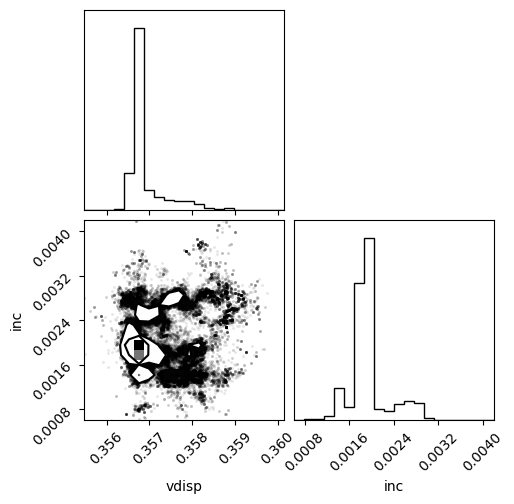

In [2]:
#Try with mcmc 
import emcee

model = "model4_emcee_vdisp"
threads = 8
fitsname = f"/home/user/THESIS/models/model4/model4.fits"
ringfile = f"/home/user/THESIS/models/model4/model4_params.txt"
output = "/home/user/THESIS/tests_all_resolution/emcee"
freepar = ['inc_single',"phi_single"]


#f3d = BayesianBBarolo(fitsname)
#th  = multiprocessing.cpu_count() #this counts my cpu so that the code can run with all of them


tabinp=np.loadtxt(ringfile,)
rad = tabinp[:,0] 
xpos= tabinp[0,8] 
ypos= tabinp[0,9]
vsys= tabinp[0,10]
vrad= tabinp[:,2]
z0=  tabinp[0,6]
inc= tabinp[0,4]
pa= tabinp[0,5]
vrot= tabinp[:,1]
vdisp= tabinp[:,3]
dens=tabinp[:,7]


# Creating an object for bayesian barolo
f3d = BayesianBBaroloMod(fitsname)

# Initializing rings. 
f3d.init(radii=rad,xpos=xpos,ypos=ypos,vsys=0.0,\
         vrot=vrot,vdisp=vdisp,vrad=vrad,z0=z0,inc=inc,phi=pa,dens=dens)

# Here it is possible to give any other BBarolo parameter, for example to control
# the mask, linear, bweight, cdens, wfunc, etc...
f3d.set_options(mask="NONE",linear=0,outfolder=f"output/{model}",plotmask=True)
# Setting up all the needed class attributes
f3d._setup(freepar,useBBres=False)

def likelihood(theta):

    cosinc,pa = theta
    if cosinc<0 or cosinc>1 or pa<-np.pi or pa>np.pi :
        return -np.inf,  -np.inf 


    thetain=np.array([np.degrees(np.arccos(cosinc)),np.degrees(pa)])
    
    ll = f3d._log_likelihood(thetain)
    
    if np.isfinite(ll): return ll, ll
    else: return -np.inf,  -np.inf 


ndim, nwalkers = 2, 30

p0=np.zeros(shape=(nwalkers,ndim))
#p0[:,0]=np.random.uniform(1,100,size=nwalkers)
p0[:,0]=np.random.uniform(0.1,0.9,size=nwalkers)
p0[:,1]=np.random.uniform(-np.pi,np.pi,size=nwalkers)
print("Initial positions of walkers:")
print(p0)


with Pool(8) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, likelihood, pool=pool)
    sampler.run_mcmc(p0, 10000, progress=True)

flat_samples = sampler.get_chain(flat=True,discard=100)
fig = corner.corner(flat_samples, labels=["vdisp","inc","pa"], truths=[np.cos(np.radians(70)),np.radians(0)])

#xx=np.linspace(0,1,100)

#ll=[]
#for x in xx:
#    ll.append(likelihood(x))


#import matplotlib.pyplot as plt
#plt.plot(np.degrees(np.arccos(xx)),ll)
#plt.show()



    

ValueError: Provided figure has 4 axes, but data has dimensions K=4

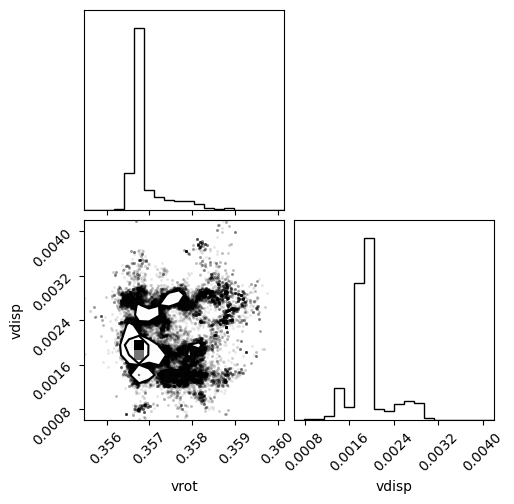

In [3]:
import corner
flat_samples = sampler.get_chain(flat=True,discard=100)
fig = corner.corner(flat_samples, labels=["vrot","vdisp","inc","pa"], truths=[100,10,np.cos(np.radians(70)),np.radians(0)])
fig.savefig(f'{output}/{model}/{model}_corner.pdf',bbox_inches='tight')

In [ ]:
np.cos(np.radians(70))

np.float64(0.3420201433256688)

In [ ]:
    _vdisp,cosinc,pa = theta

    if cosinc<0 or cosinc>1 or _vdisp<0 or _vdisp>300 or pa<0 or pa>2*np.pi:
       return -np.inf, -np.inf
    
    thetain = np.array([_vdisp, np.degrees(np.arccos(cosinc)), np.degrees(pa)])

    ll = f3d._log_likelihood(thetain)

    if np.isfinite(ll):
        return ll, ll
    else:
        return -np.inf, -np.inf